Capstone Project VII Unsupervised Machine Learning

In [200]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize

from sklearn.decomposition import PCA
from pca import pca

from sklearn.metrics import accuracy_score, silhouette_score

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as shc

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

import warnings 
warnings.filterwarnings('ignore')

In [201]:
# Read in from the data file
data = pd.read_csv('UsArrests.csv')
data.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.200,236,58,21.200
1,Alaska,10.000,263,48,44.500
2,Arizona,8.100,294,80,31.000
3,Arkansas,8.800,190,50,19.500
4,California,9.000,276,91,40.600


We can see that we have one dependent variable - City (actually the state) - and 4 independent variables.  I will just check the nature and quality of the data before starting any work.

In [202]:
# Check the type of data in each column
city = data['City']
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


Two columns contain integers and two floats, so I will convert the integer values to float.

In [203]:
# convert integers to float so they are all the same
data['Assault'] = data['Assault'].astype('float64')
data['UrbanPop'] = data['UrbanPop'].astype('float64')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     float64
 3   UrbanPop  50 non-null     float64
 4   Rape      50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [204]:
# checking for missing values
data.isnull().sum()

City        0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

The dataframe contains no missing values so is ready to work with.

In [205]:
# Just examining the nature of the data in each column
data.describe()
labels = data.columns

,Murder,Assault,UrbanPop,Rape
count,50.000,50.000,50.000,50.000
mean,7.788,170.760,65.540,21.232
std,4.356,83.338,14.475,9.366
min,0.800,45.000,32.000,7.300
25%,4.075,109.000,54.500,15.075
50%,7.250,159.000,66.000,20.100
75%,11.250,249.000,77.750,26.175
max,17.400,337.000,91.000,46.000


There are 50 lines of data and it looks like UrbanPop is a percentage figure whereas the other columns contain absolute values.

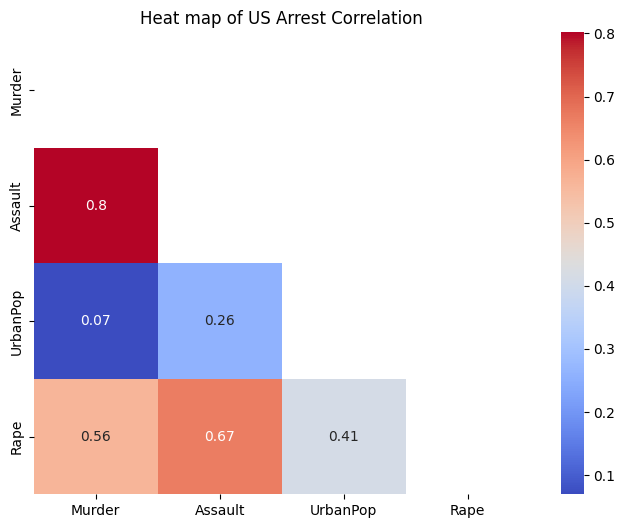

In [206]:
# looking for correlation in the dataset
plt.figure(figsize=(8,6))
Arrest_corr = data.corr()
# mask mirrored side of heatmap
dropmirror = np.zeros_like(Arrest_corr)
dropmirror[np.triu_indices_from(dropmirror)] = True

sns.heatmap(Arrest_corr, annot=True, mask=dropmirror, cmap='coolwarm')
plt.title('Heat map of US Arrest Correlation')
plt.show()

In this chart cool blue colours represent lower correlation e.g. between UbanPop and Murder.  The warmer red colours represent higher correlation, notably there is a strong correlation between Murder and Assault and to a slightly lesser extent between Assault and Rape.

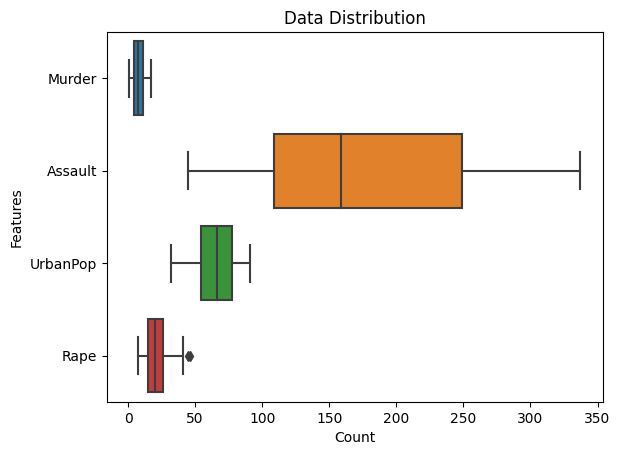

In [207]:
# Creating a box plot to show feature distribution
sns.boxplot(data=data, orient='h')
plt.ylabel('Features')
plt.xlabel('Count')
plt.title("Data Distribution")
plt.show()

This shows that there are far more Assaults than other types of crime and also that the UrbanPop figure does not vary much between states.  Remember that this is a percentage figure - presumably the percentage of the State population that lives in Urban areas.

Data scaling is necessary to allow for proper interpretation of the data.

In [208]:
# Scaling the independent variable data
scaled = StandardScaler().fit_transform(data.iloc[:,1:5])
# Create a scaled version of the dataframe
scale_data = pd.DataFrame(scaled, columns=data.columns[1:5])
scale_data.head()

,Murder,Assault,UrbanPop,Rape
0,1.255,0.791,-0.526,-0.003
1,0.513,1.118,-1.224,2.509
2,0.072,1.494,1.009,1.053
3,0.235,0.233,-1.084,-0.187
4,0.281,1.276,1.777,2.089


Now we use PCA to select the principal components for analysis

In [209]:
pca = PCA().fit(scale_data)
pca.explained_variance_ratio_

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

We can see that the first Principal Component has a 62% variance and the second a 24.7% variance.  To utilise PCA we want to minimise the number of principal components to make the program more efficient to run, but we do want a reasonable degree of accuracy.  Therefore, I have looked below at the cumulative variance as you add the Principal Components into the model.  I would like a minimum of 85% which I have shown as a line on the graph below.

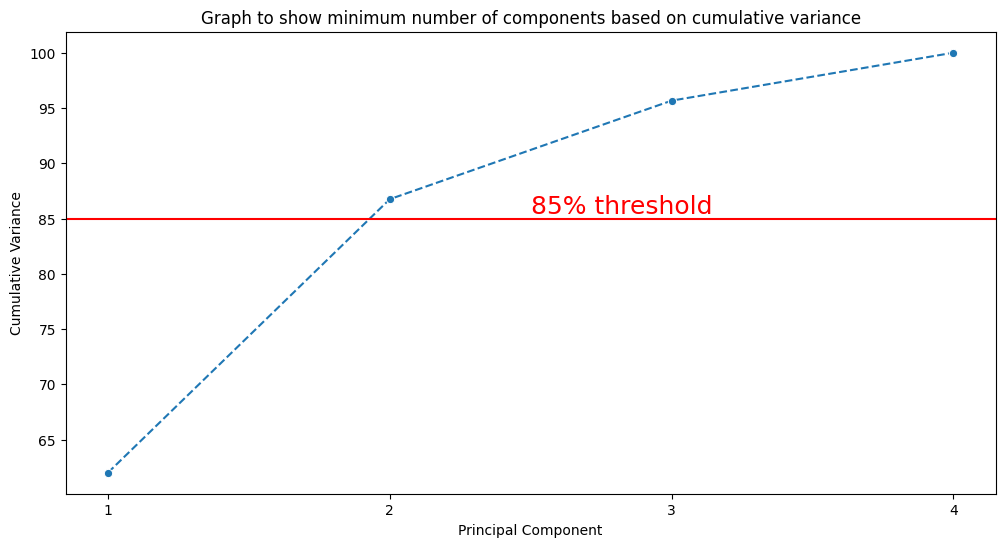

In [210]:
# creating a graph to show the minimum number of components required
X = np.arange(1, 5, step=1)
plt.figure(figsize=(12,6))
sns.lineplot(x=X, y=np.cumsum(pca.explained_variance_ratio_)*100, linestyle='--', marker = 'o')
plt.title("Graph to show minimum number of components based on cumulative variance")
plt.xlabel('Principal Component')
plt.xticks(np.arange(1,5, step=1))
plt.ylabel('Cumulative Variance')
plt.axhline(y=85, color='r', linestyle='-')
plt.text(2.5, 85.5, '85% threshold', color='r', fontsize=18)
plt.show()

From this it seems that we can proceed with 2 Principal Components as this will explain over 85% of the variance in the data.

In [211]:
# Proceding with 2 components and applying them to the scaled data
pca = PCA(n_components=2)
PC = pca.fit_transform(scale_data)
PC.shape

(50, 2)

In [212]:
# Transform components into a Pandas dataframe
PC_data = pd.DataFrame(data=PC, columns=['Principal Component 1', 'Principal Component 2'])
PC_data['City'] = data['City']
PC_data.head()

,Principal Component 1,Principal Component 2,City
0,0.986,1.133,Alabama
1,1.950,1.073,Alaska
2,1.763,-0.746,Arizona
3,-0.141,1.120,Arkansas
4,2.524,-1.543,California


<AxesSubplot: title={'center': 'Variance Explained by Principal Components'}, xlabel='principal component', ylabel='variance explained'>

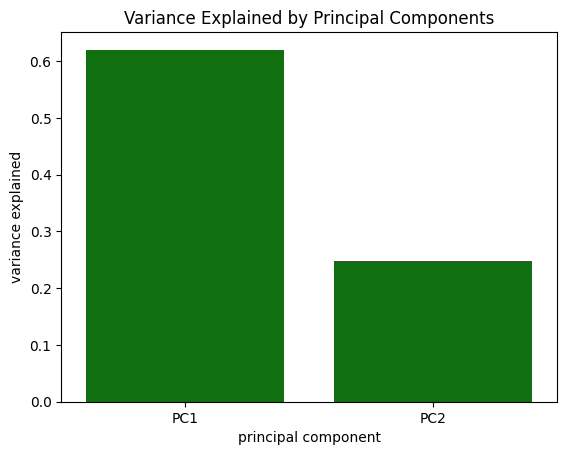

In [213]:
# Create a barplot to show how each component affects the variance
df = pd.DataFrame({'variance explained' : pca.explained_variance_ratio_, 'principal component' : ['PC1', 'PC2']})
plt.title('Variance Explained by Principal Components')
sns.barplot(x = 'principal component', y = 'variance explained', data=df, color='g')

Finally I'd like to look at how each principal component is influenced by the original features of the dataset.  I find this easiest to visualise as a list as shown below.

In [214]:
# Feature importance
pd.set_option('display.float_format', lambda x: '%.3f' % x) #change precision to see more decimal places

pc1 = abs( pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.536,0.418
1,Assault,0.583,0.188
2,UrbanPop,0.278,0.873
3,Rape,0.543,0.167


Principal Component 1 is influenced to a fairly even extent by the crime features of the original dataframe, but not as much by the urban population.  Principal Component 2 is mainly influenced by the Urban Population followed by the Murder rates.

In [218]:
pca_df = pd.DataFrame(PC[:,0:2], index=city)
pca_df.head()

,0,1
City,,
Alabama,0.986,1.133
Alaska,1.950,1.073
Arizona,1.763,-0.746
Arkansas,-0.141,1.120
California,2.524,-1.543


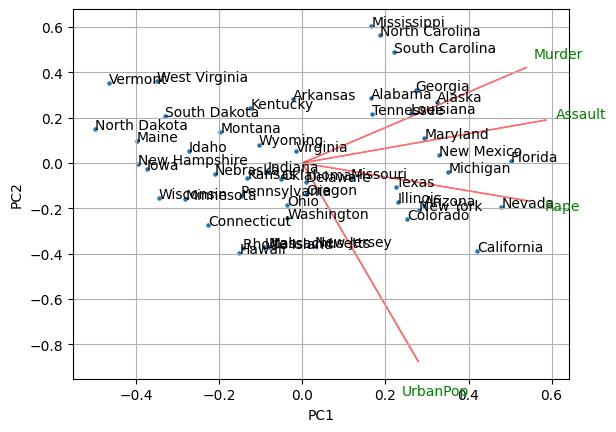

In [235]:
# produce a biplot to show the original data points against the background of the two principal components
# also shows the vectors of the original features
biplot(PC[:,0:2],np.transpose(pca.components_[0:2, :]),list(labels))
plt.show()

Now that we have our Principal Components, we can perform some cluster analysis on the dataset.  Firstly, we will perform Hierarchical clustering using Agglomerative clustering.

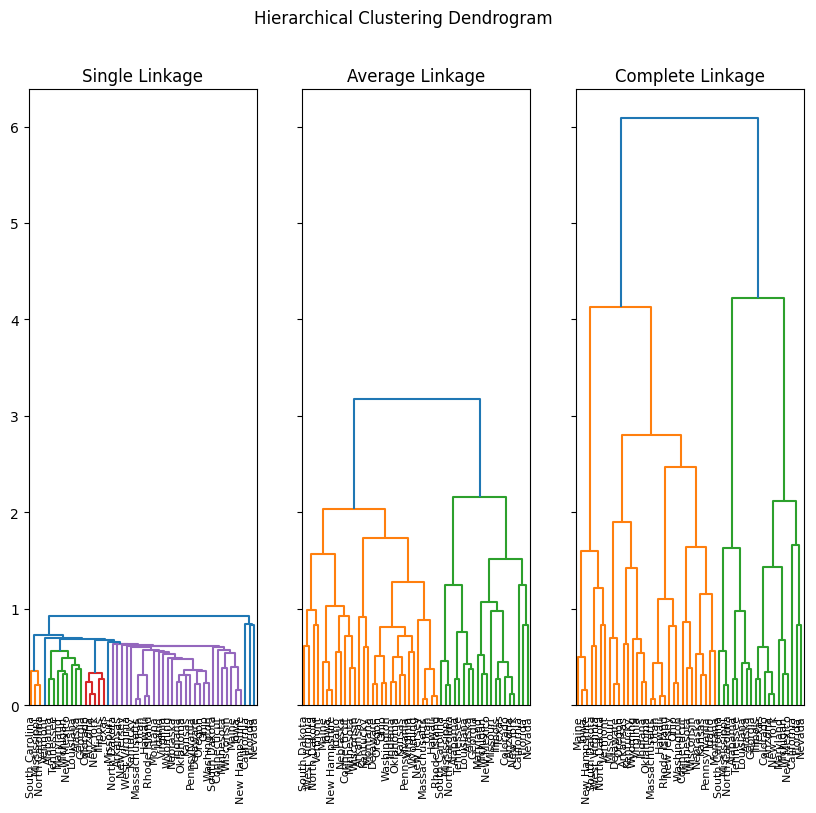

In [236]:
# plotting out the clustering models for different types of linkage
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_df)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,8), sharey=True)
fig.suptitle('Hierarchical Clustering Dendrogram')

ax1.set_title("Single Linkage")
dendrogram(linkage(pca_df, method='single'), labels=pca_df.index, ax=ax1) #change method: eg. single, average, complete...
ax2.set_title("Average Linkage")
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index, ax=ax2)
ax3.set_title("Complete Linkage")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index, ax=ax3)
plt.show()

I have made the y-axes the same scale in the above so that you can see that the model that produces clusters with the largest separation is the one with complete linkage.  Producing this graph again for more detail

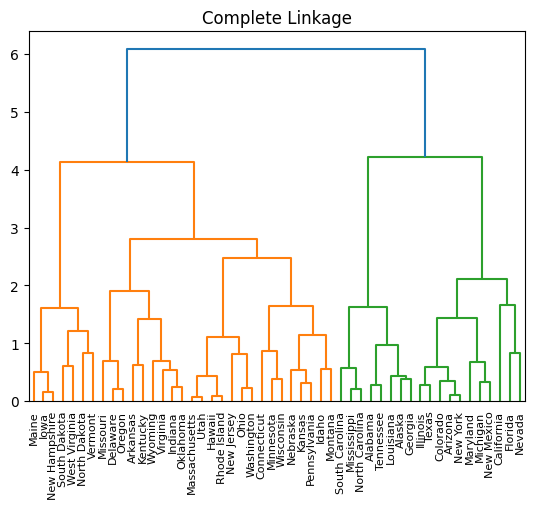

In [237]:
plt.title('Complete Linkage')
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index)
plt.show()

This analysis produces two distinct clusters with 31 States in the first orange cluster and 19 States in the second green cluster.  I can see from the above that States that contain some of the biggest cities and built up areas in the US are in the green cluster - New York, California (Los Angeles), Chicago (Michigan), Miami (Florida) etc, even though urban population was not a large factor of the first Principal Component. 

Next to try another clustering approach: K-means Clustering.  I will initially try k=2, i.e. two clusters as that seems to be the number indicated by the Agglomerative Clustering approach above.

Text(0, 0.5, 'Dim 1')

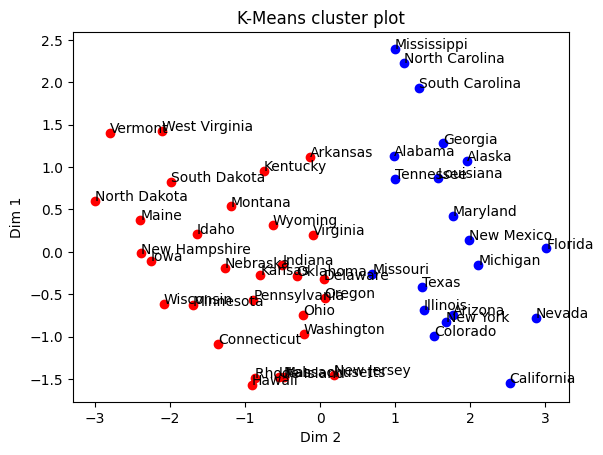

In [241]:
# Extract the first two components
x = PC[:,0]
y = PC[:,1]

# Fit k-means
k=2
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = city[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
#ax.legend()

The clusters are broadly similar to those found in the Agglomerative Clustering method although Missouri (which is between the two clusters on the graph above) has been put in a different cluster this time.